# Finetuning

This tutorial illustrates how to fine-tune the `GR00T-N1` pretrained checkpoint on a post-training 
dataset using the same embodiment. This showcases the benefit of post-training, transforming a generalist model into a specialist and demonstrating a performance gain.

For this tutorial, we will use the demo dataset `robot_sim.PickNPlace` from the [demo_data](./demo_data) folder. 

We will first load the pre-trained model and evaluate it on the dataset. Then we will finetune the model on the dataset and evaluate the performance.

## Pre-trained Model

In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-11 15:49:24.088651: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 15:49:24.107701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:

In [2]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1-2B"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../novideo_data"
from gr00t.data.dataset import ModalityConfig
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform

data_config = DATA_CONFIG_MAP["gr1_arms_only"]
modality_config = {
    "video": ModalityConfig(
        delta_indices=[0],
        modality_keys=["video.ego_view"],
    ),
    "state": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "state.left_arm",
            "state.right_arm"
        ],
    ),
    "action": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "action.left_arm",
            "action.right_arm",
        ],
    ),
    "language": ModalityConfig(
        delta_indices=[0],
        modality_keys=["annotation.human.action.task_description"] #, "annotation.human.validity"],
    ),
}

observation_indices = [0]
action_indices = list(range(16))
video_modality = modality_config["video"]
state_modality = modality_config["state"]
action_modality = modality_config["action"]
modality_transform = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear"),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            key: "min_max" for key in state_modality.modality_keys
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            key: "min_max" for key in action_modality.modality_keys
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        GR00TTransform(
            state_horizon=len(observation_indices),
            action_horizon=len(action_indices),
            max_state_dim=64,
            max_action_dim=32,
        )
    ]
)

pre_trained_policy = Gr00tPolicy(
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)


mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 153450.15it/s]


Loading pretrained dual brain from /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Total number of DiT parameters:  537803776


Some weights of the model checkpoint at /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 11.60 GiB of which 71.94 MiB is free. Process 446979 has 4.50 GiB memory in use. Process 475187 has 4.50 GiB memory in use. Including non-PyTorch memory, this process has 1.25 GiB memory in use. Of the allocated memory 1.03 GiB is allocated by PyTorch, and 33.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Great! we can see the predicted actions and the ground truth actions. The predicted actions are not perfect but they are close to the ground truth actions. That's show that the pretrained checkpoint is working well.

Now let's sample 10 random trajectories and calcuate the mean MSE to get a sense of more verbose results.

Total trajectories: 4
Sampled trajectories: [2 0 3 0 2 0 0 1 0 2]
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.3997964511609866


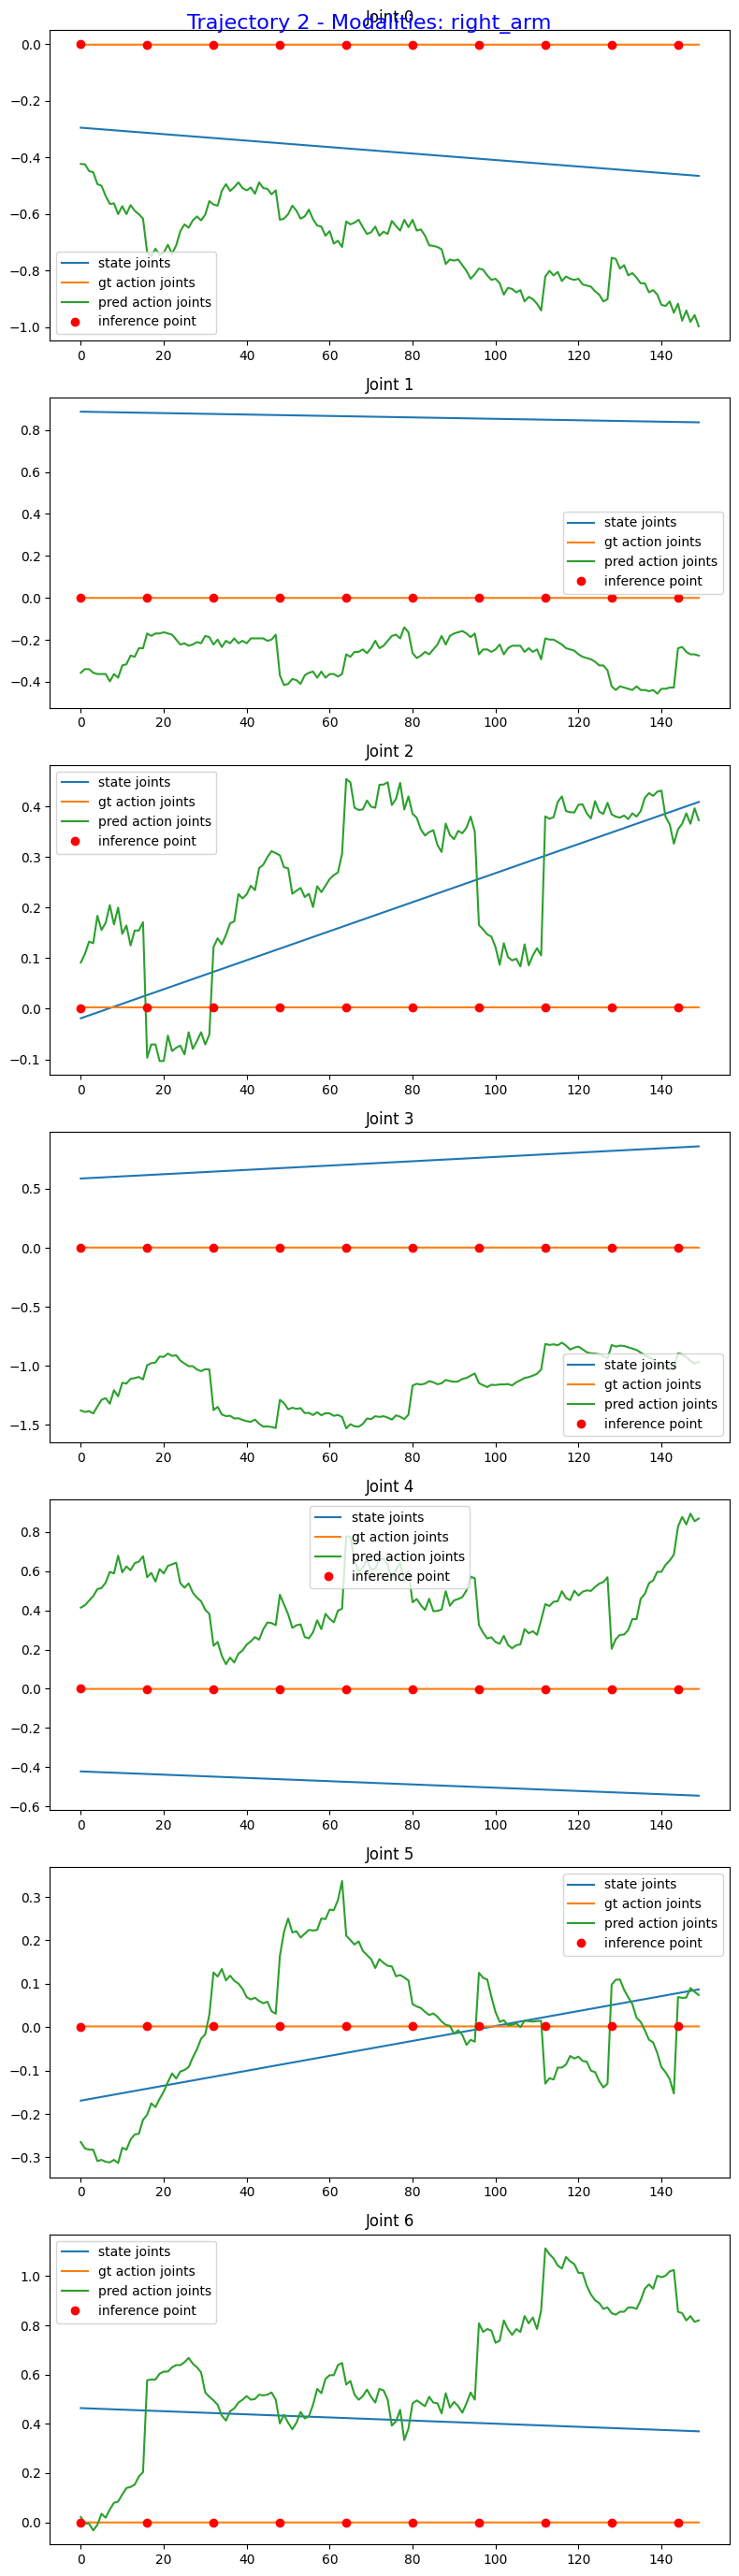

Trajectory 2 MSE: 0.3998
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.34256126582999125


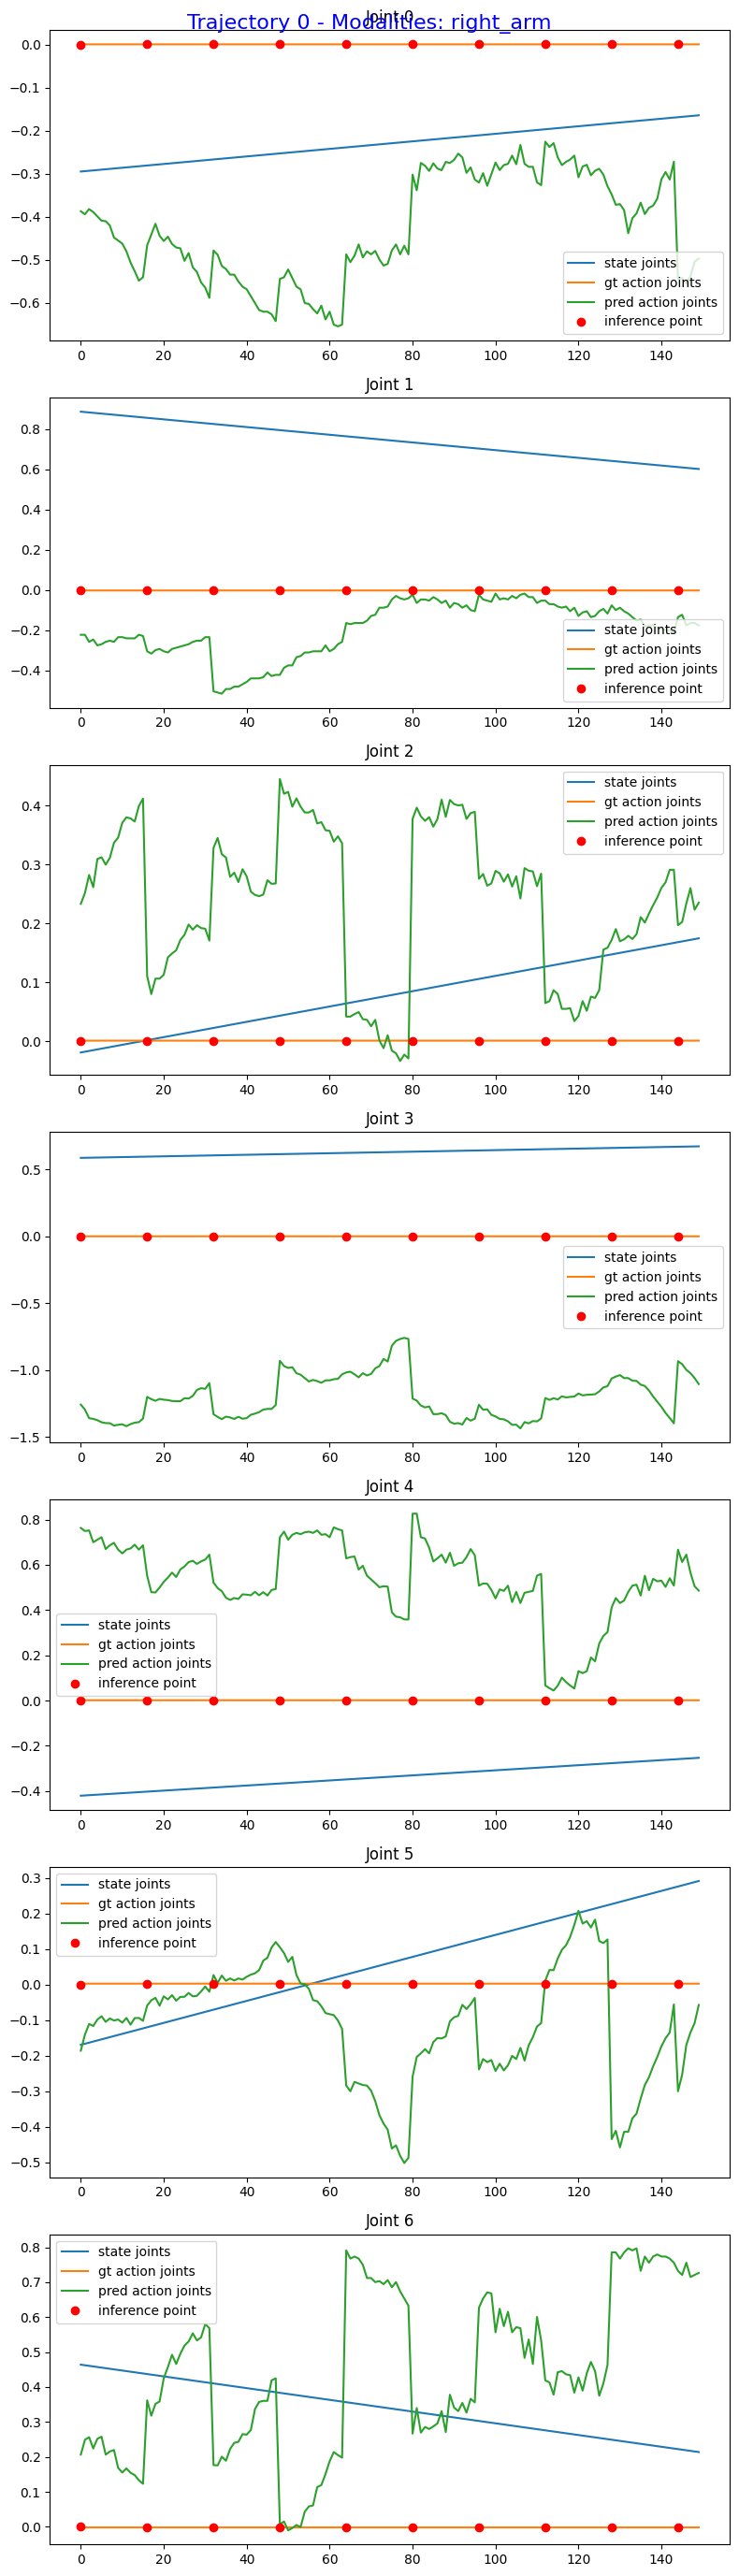

Trajectory 0 MSE: 0.3426
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.41512066956188803


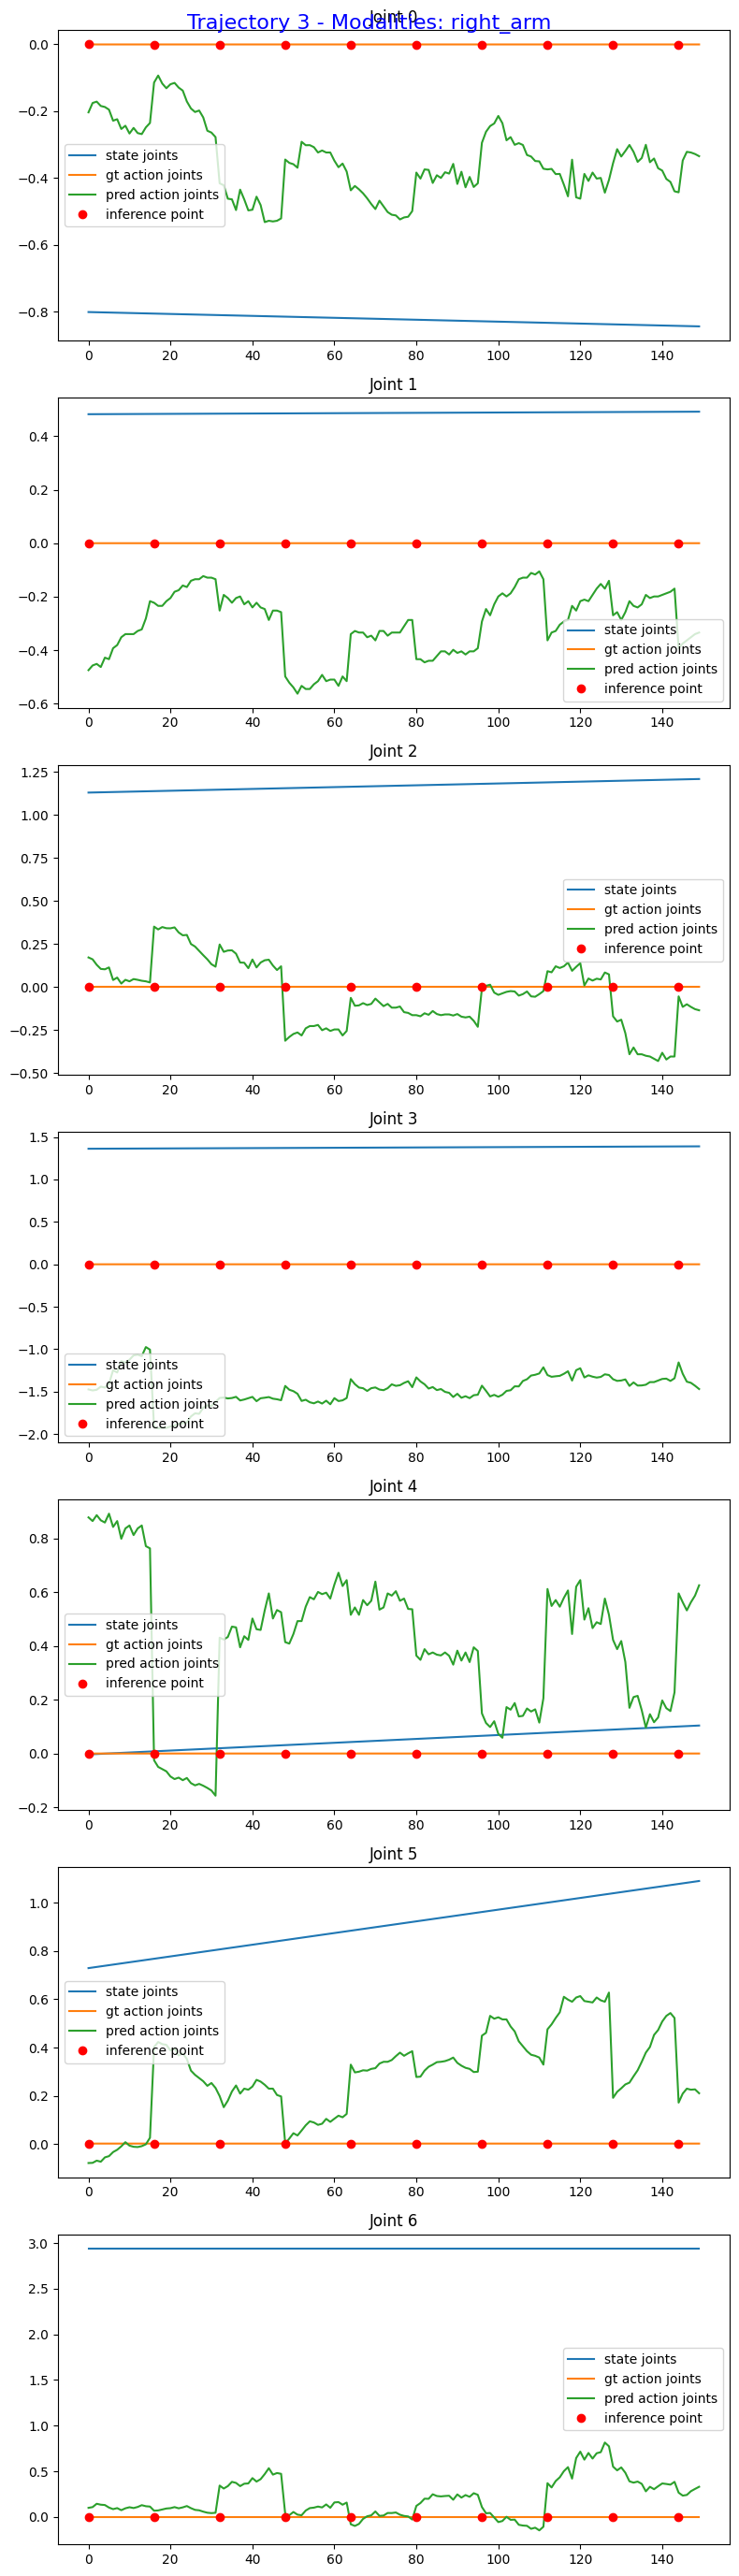

Trajectory 3 MSE: 0.4151
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.34038096979821825


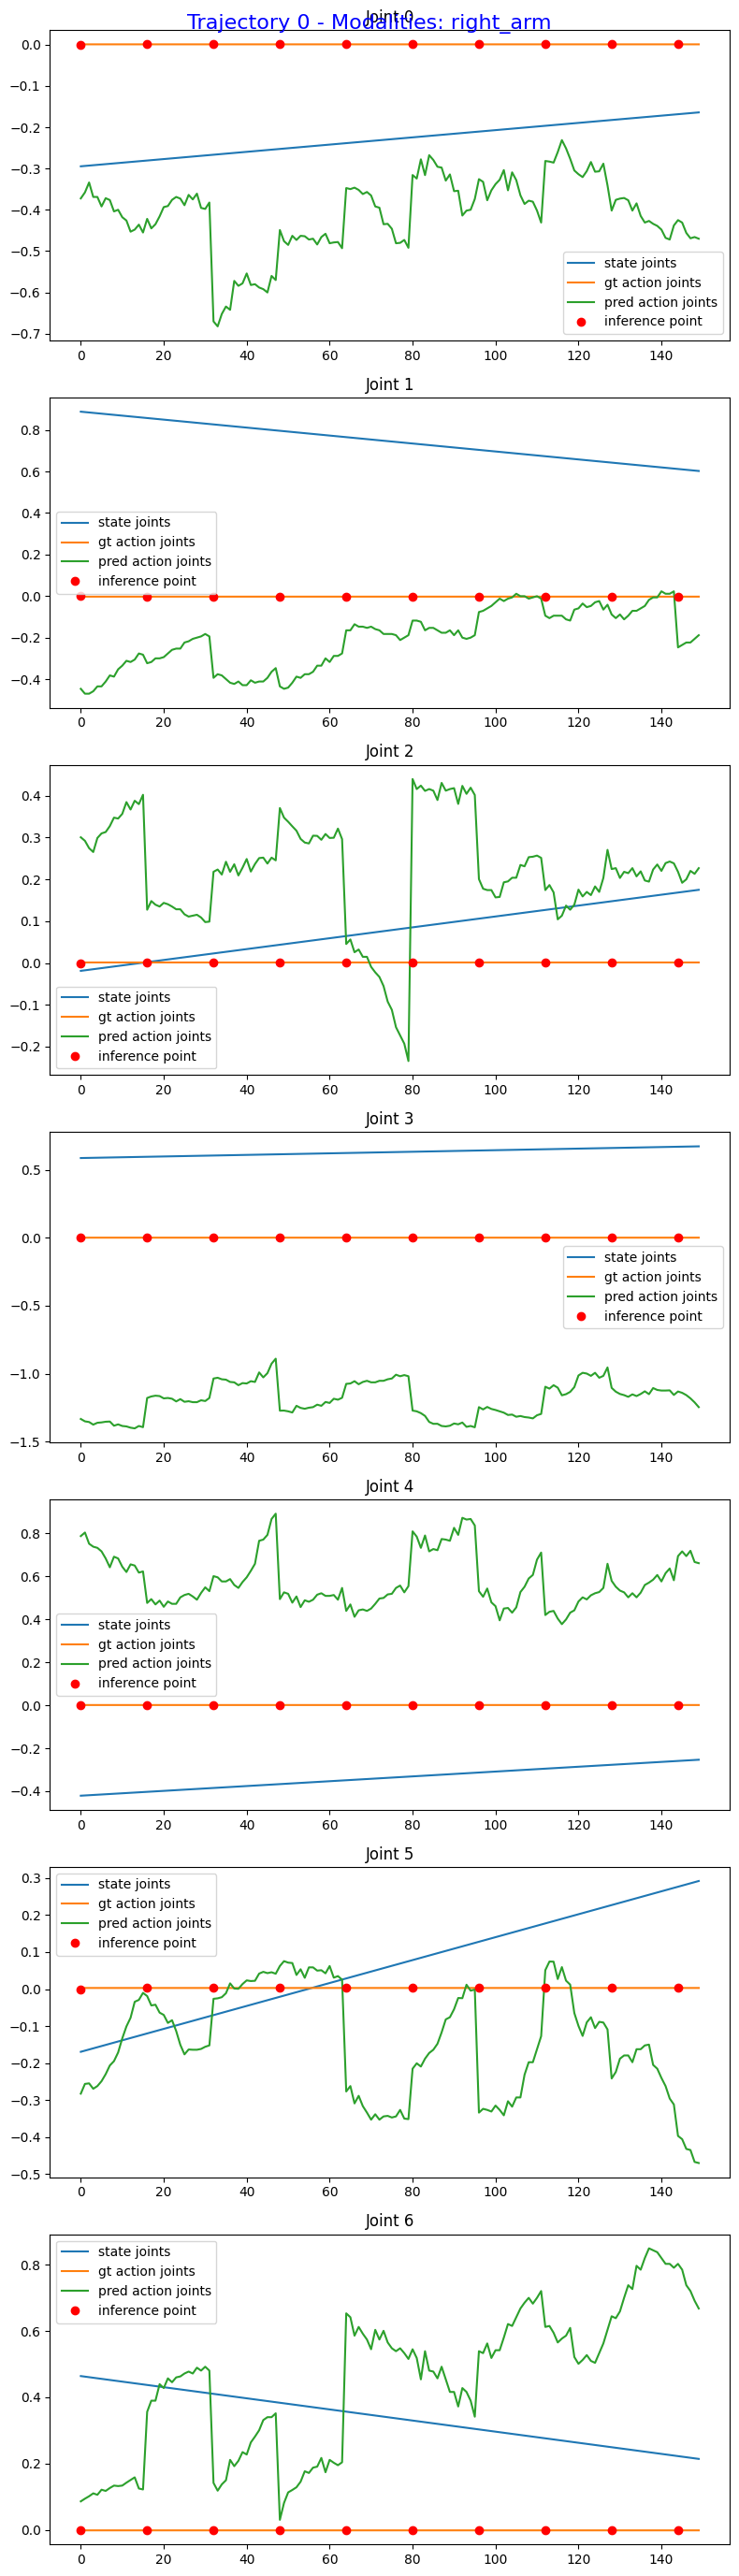

Trajectory 0 MSE: 0.3404
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.42481627742173617


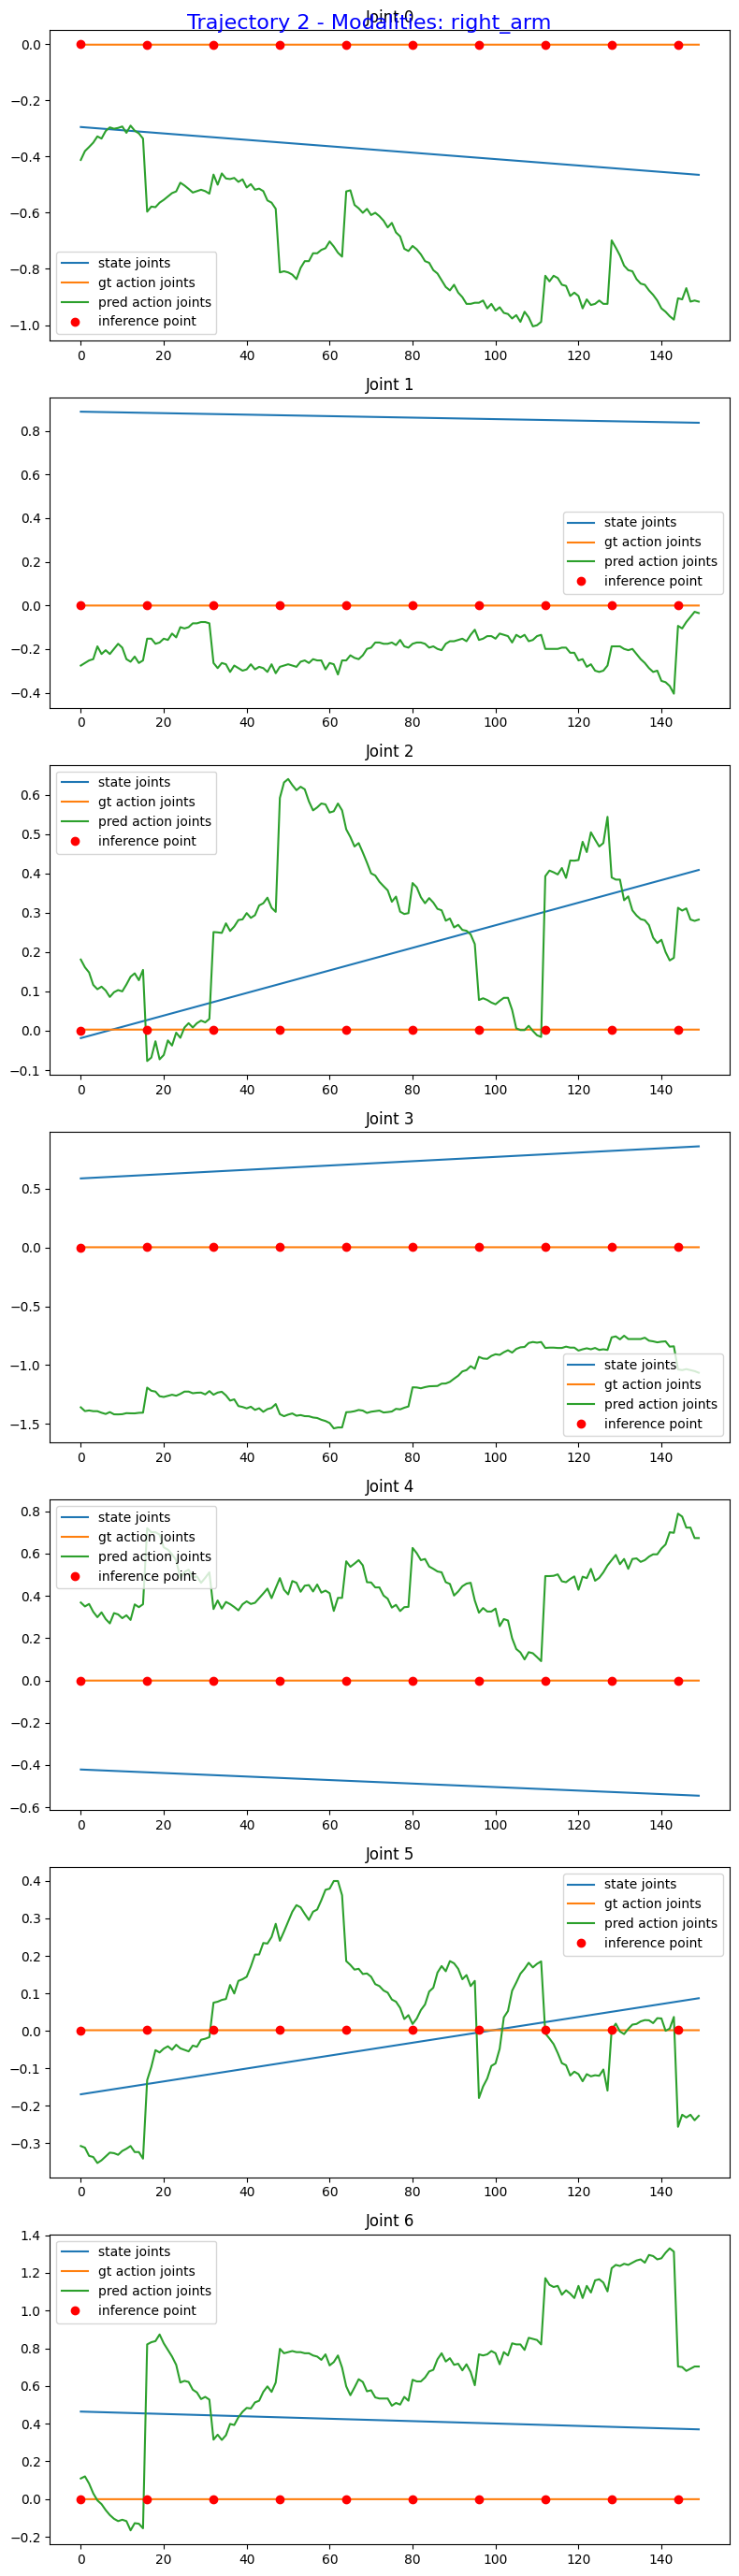

Trajectory 2 MSE: 0.4248
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.35879967394760204


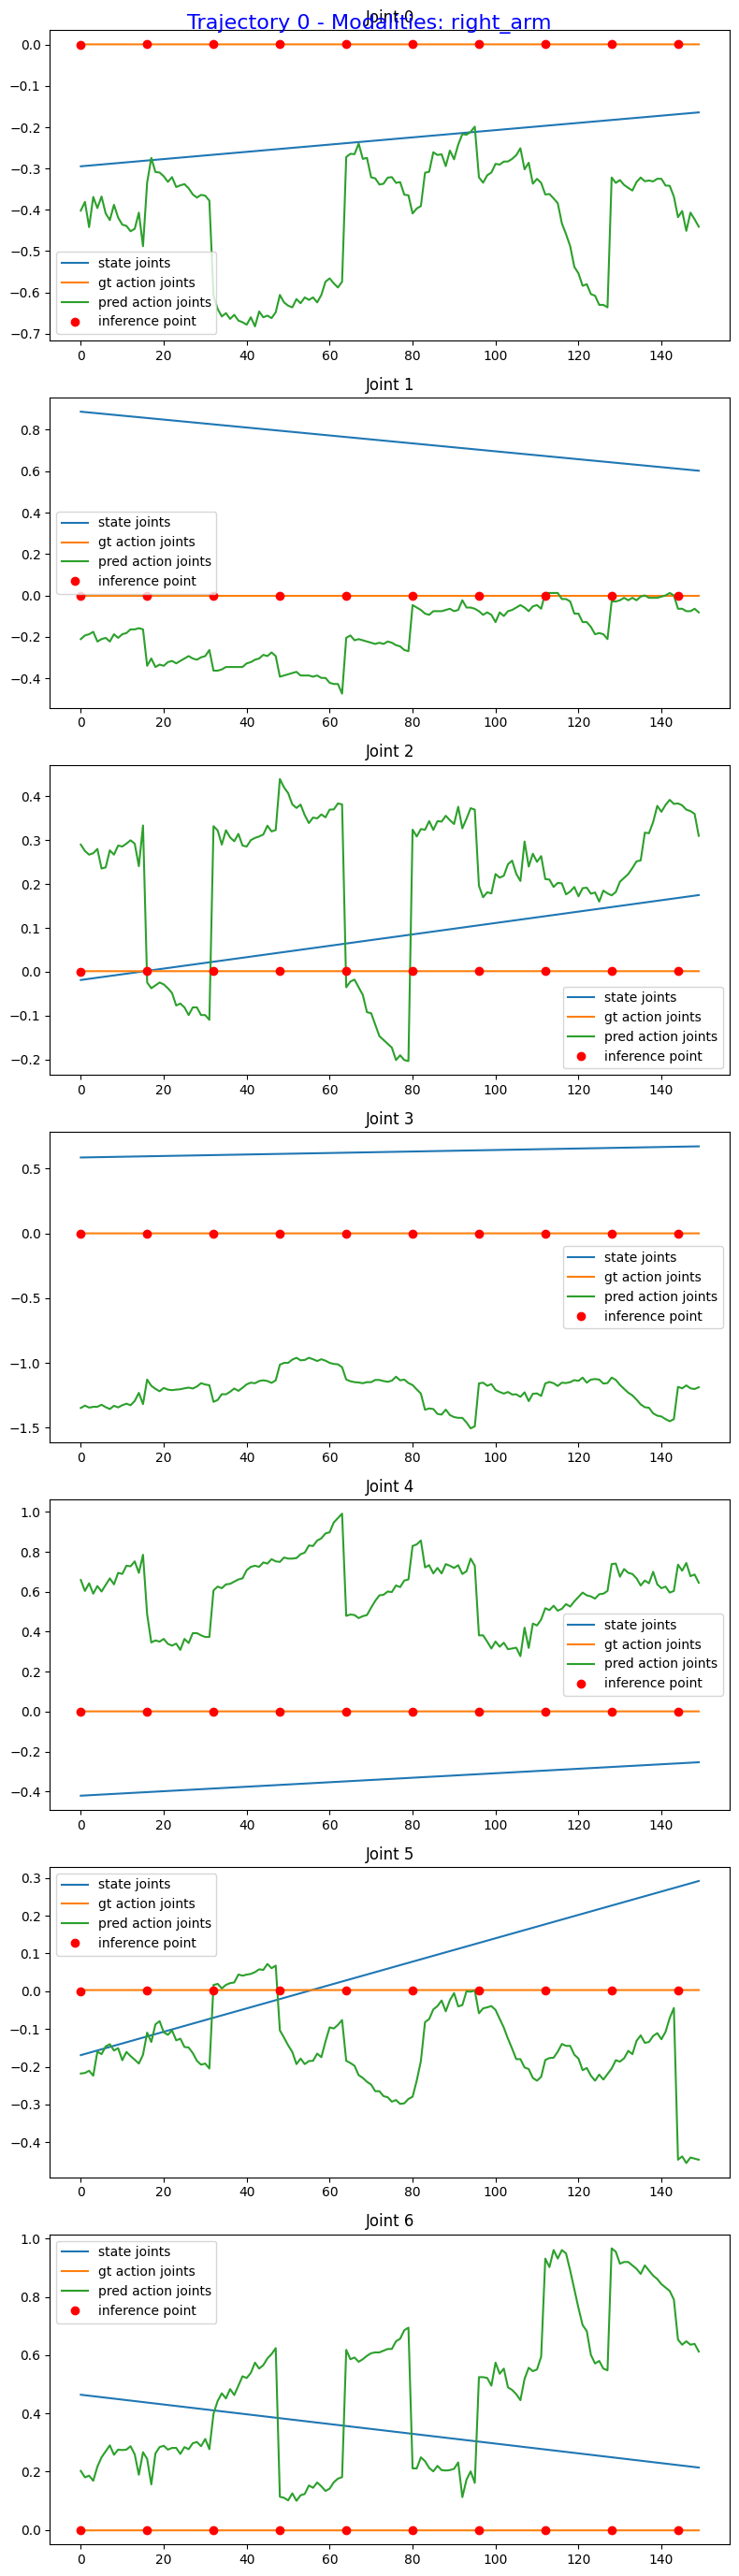

Trajectory 0 MSE: 0.3588
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.35907400133373174


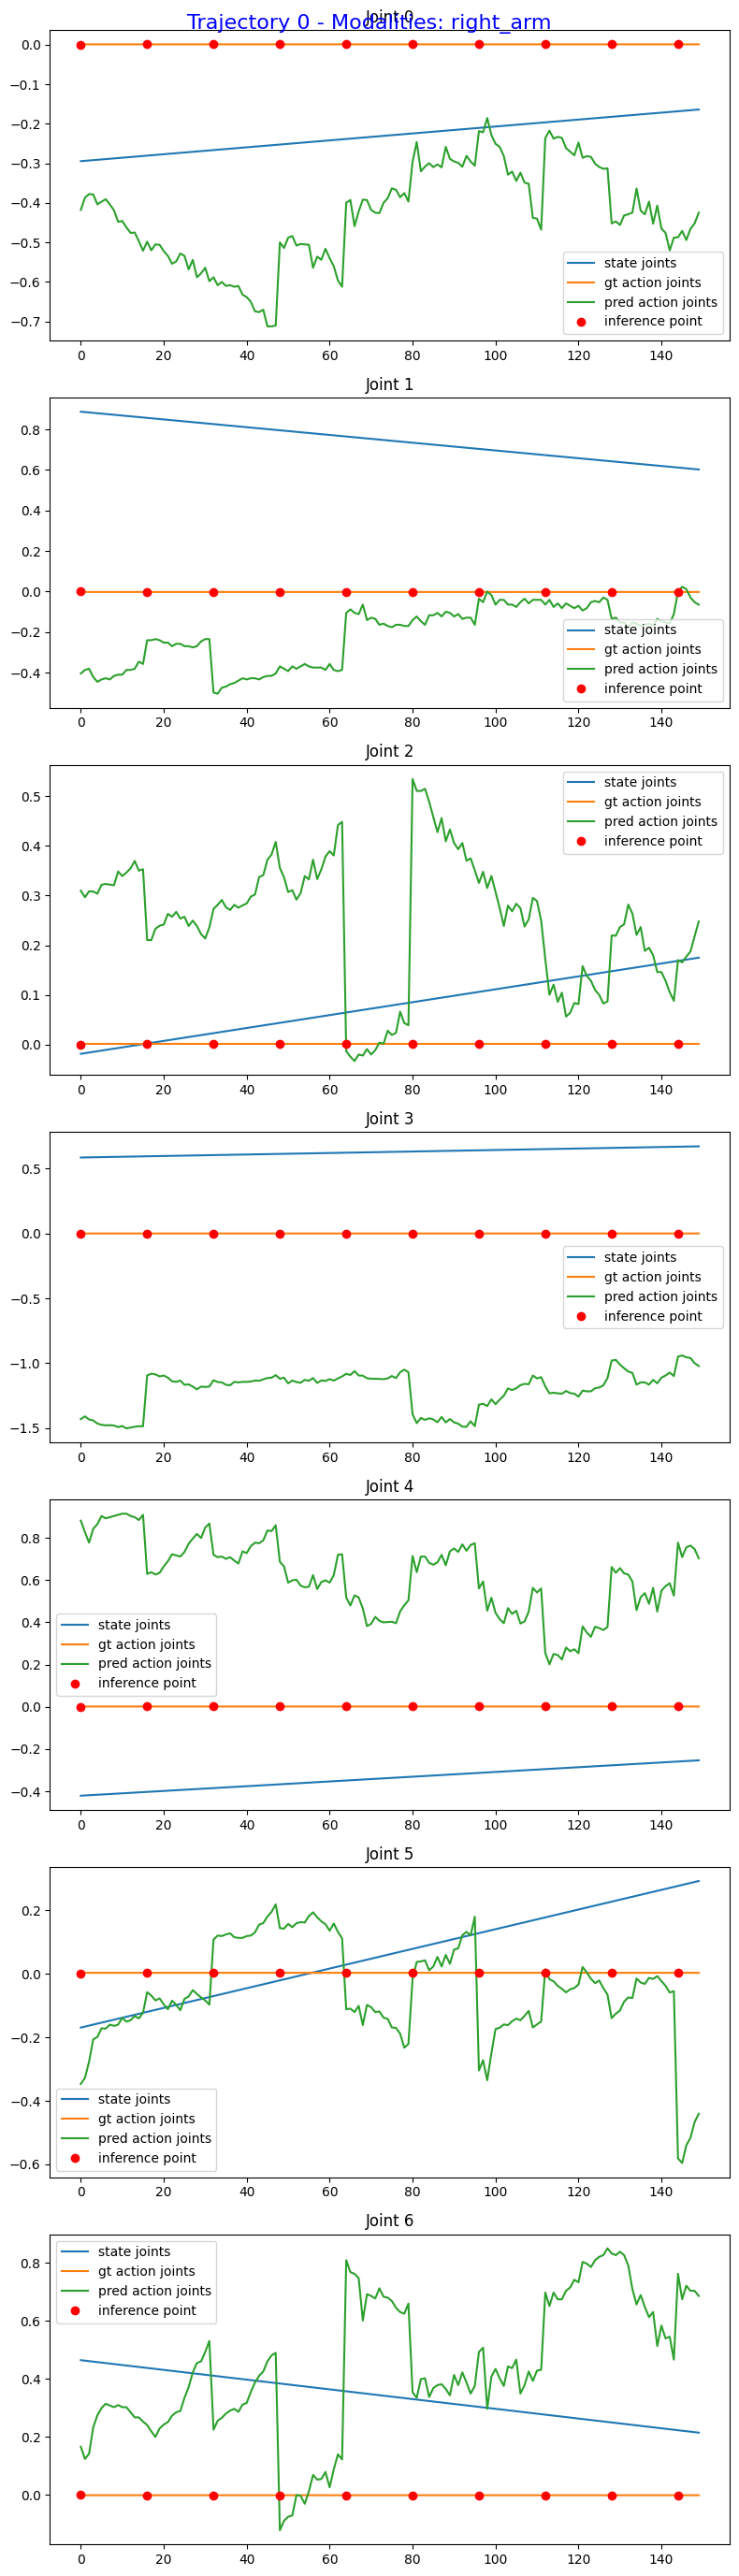

Trajectory 0 MSE: 0.3591
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.5120283080322586


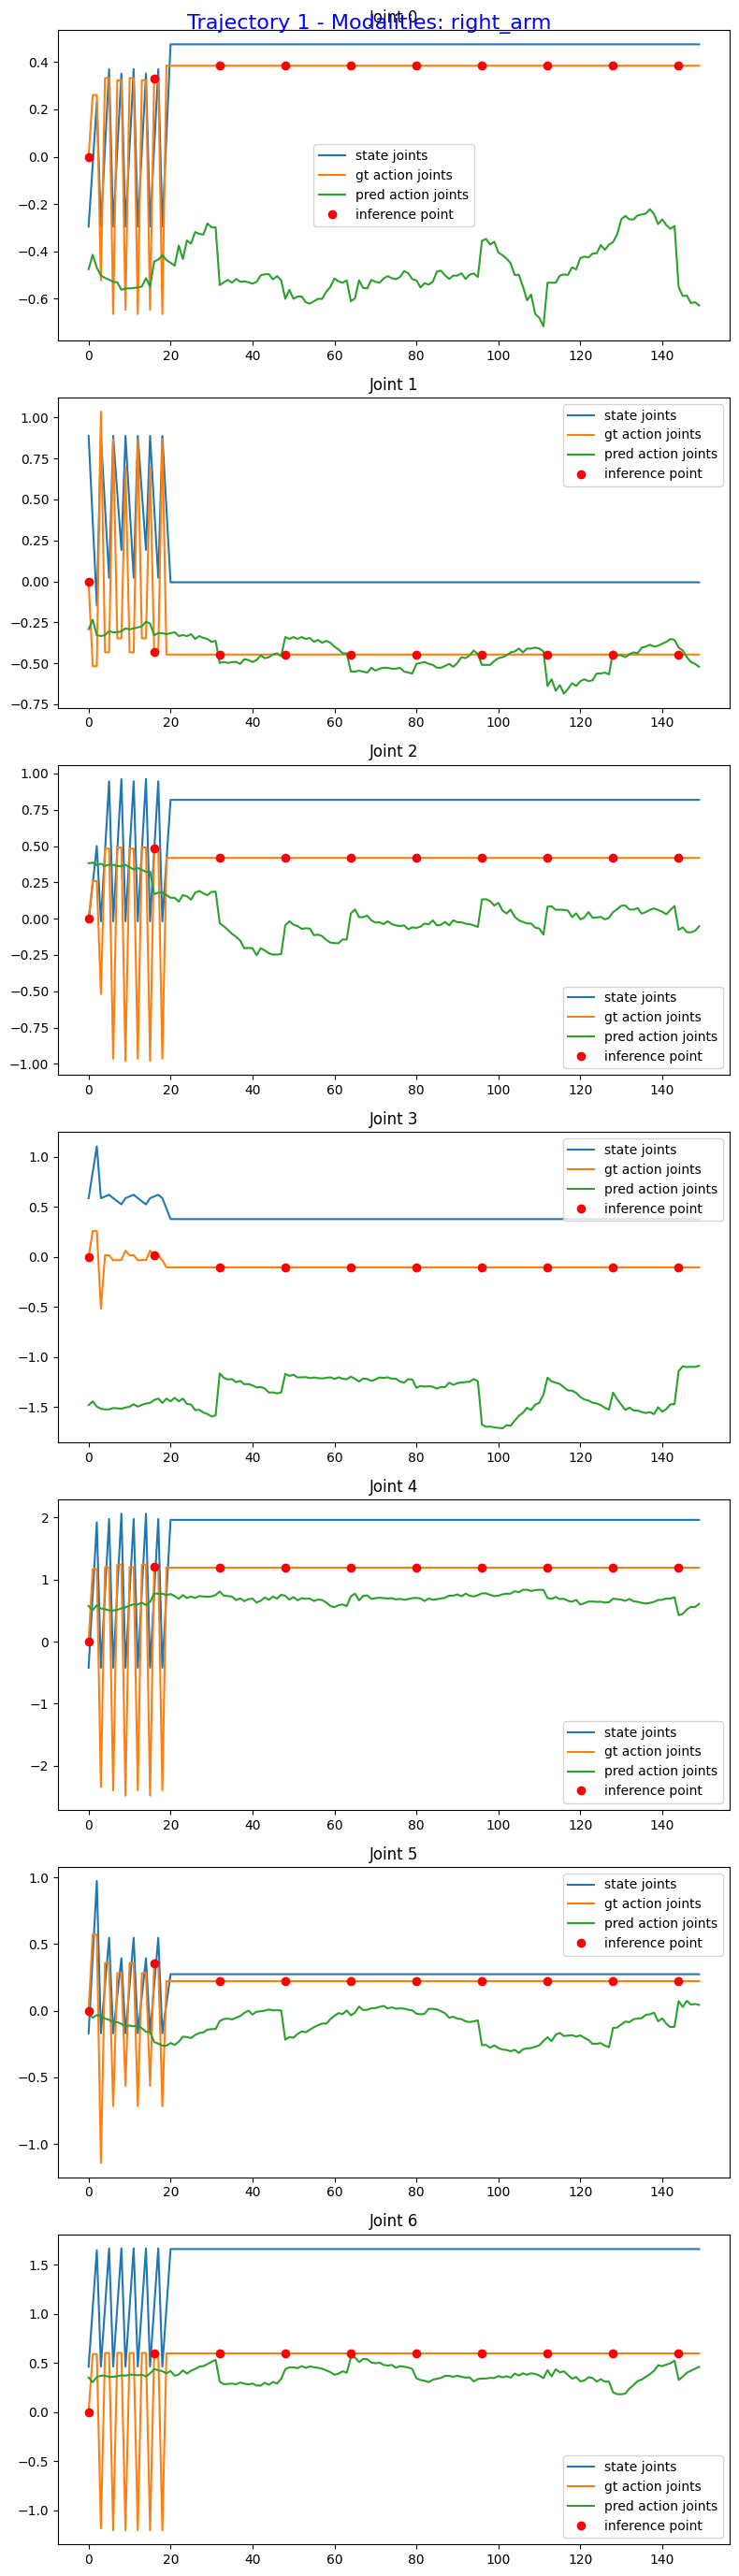

Trajectory 1 MSE: 0.5120
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.35533081507631004


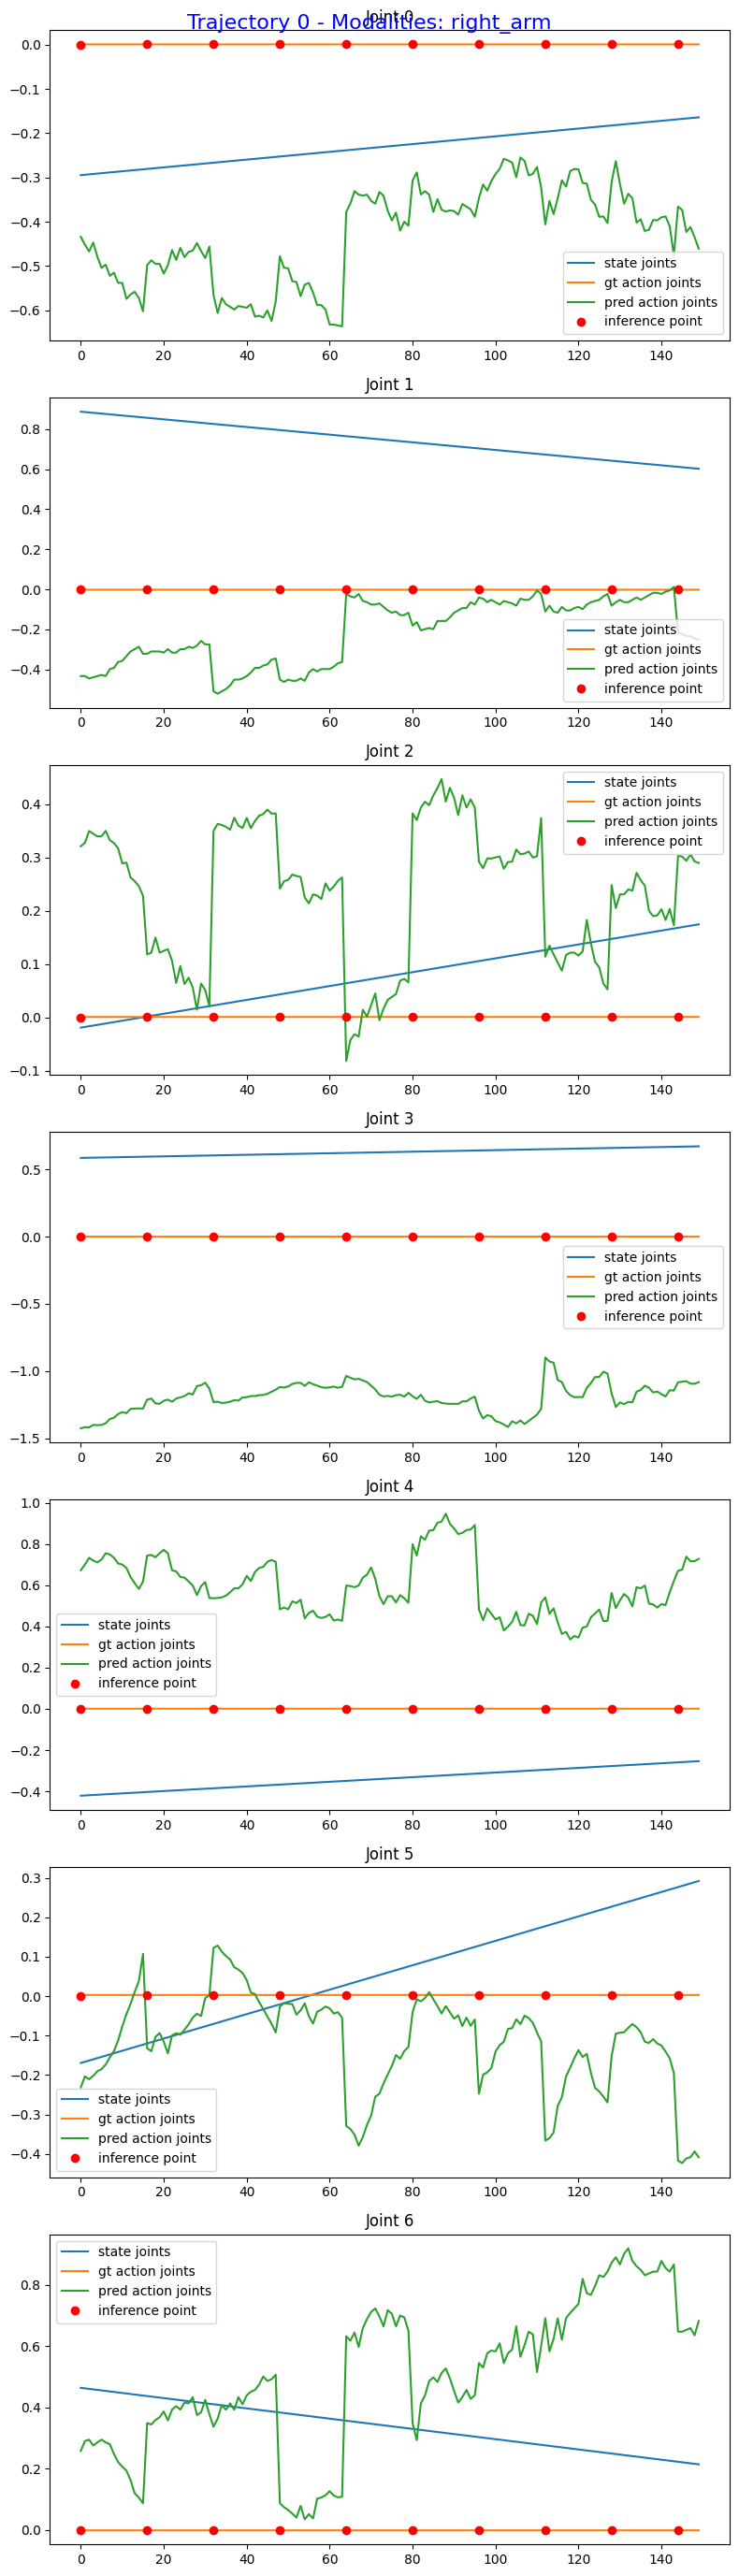

Trajectory 0 MSE: 0.3553
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.4432384939373375


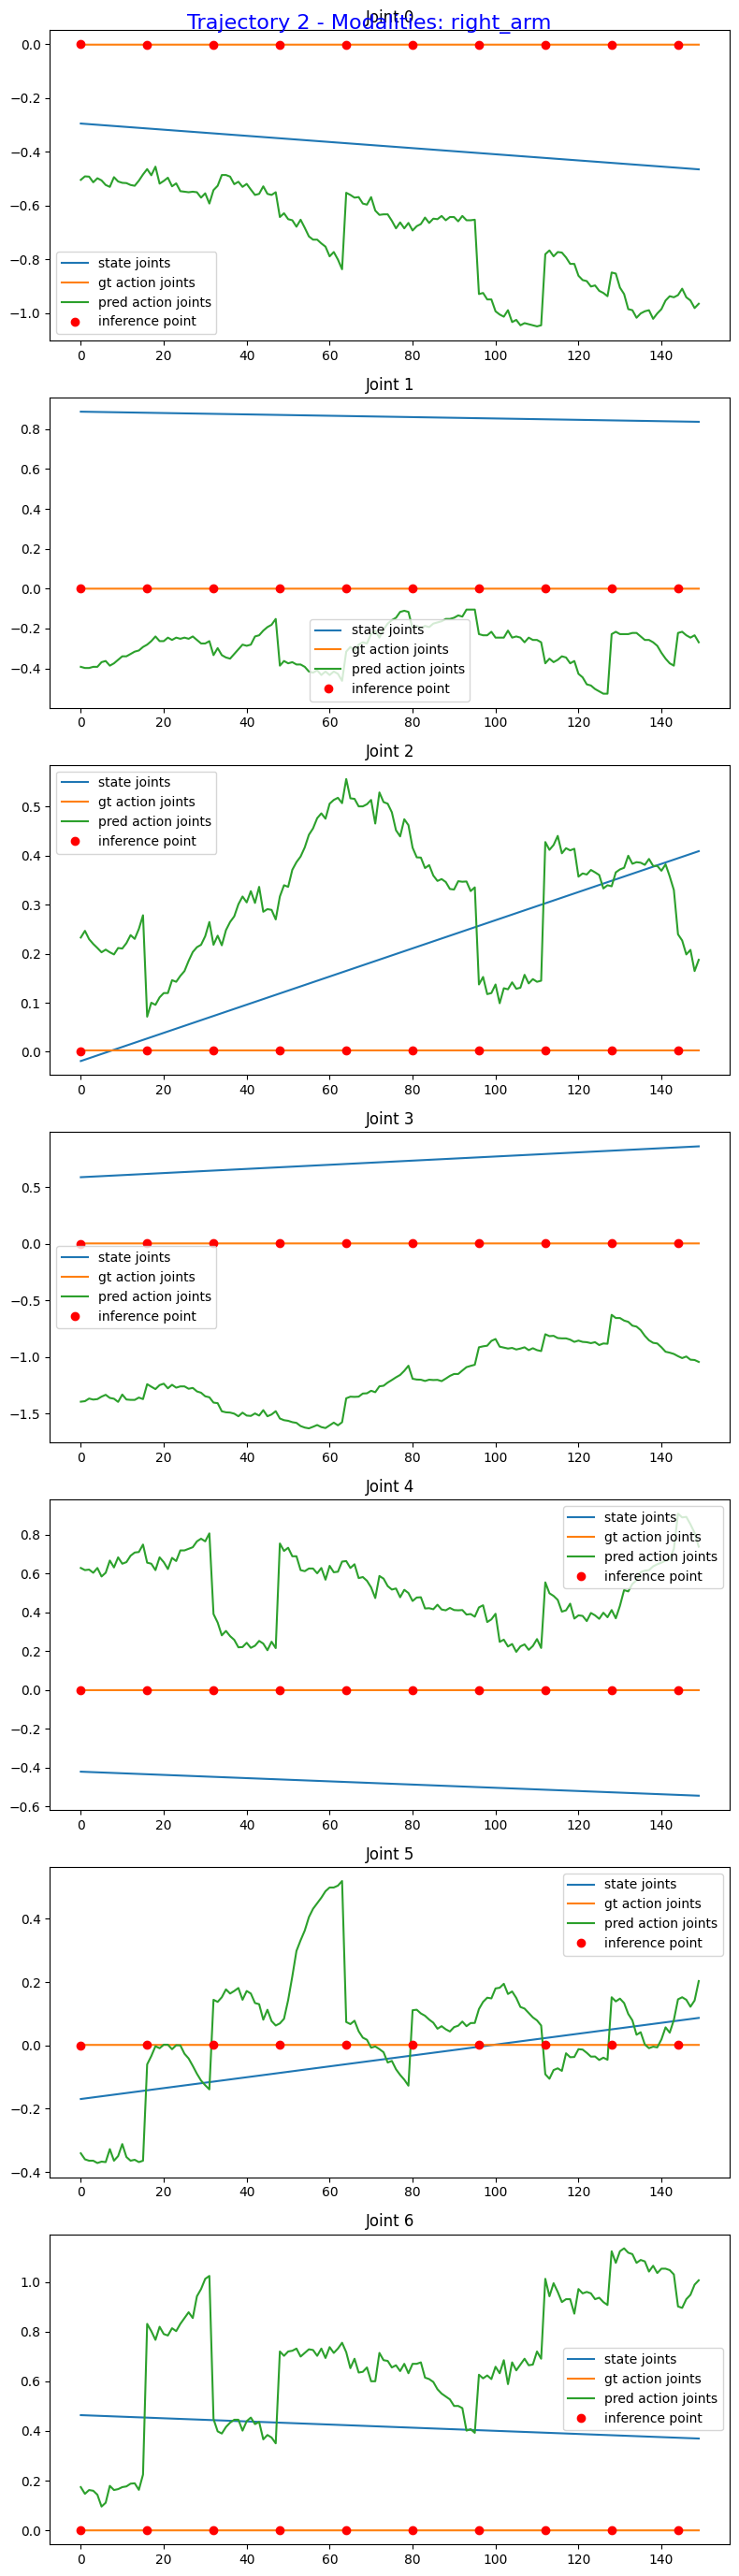

Trajectory 2 MSE: 0.4432
Mean MSE: 0.39511469261000604
Std MSE: 0.05219880060063712


In [ ]:
total_trajectories = len(dataset.trajectory_lengths)

print("Total trajectories:", total_trajectories)

sampled_trajectories = np.random.choice(total_trajectories, 10)
print("Sampled trajectories:", sampled_trajectories)

all_mses = []

for traj_id in sampled_trajectories:
    mse = calc_mse_for_single_trajectory(
        pre_trained_policy,
        dataset,
        traj_id=traj_id,
        modality_keys=["right_arm"],   # we will only evaluate the right arm and right hand
        steps=150,
        action_horizon=16,
        plot=True
    )
    print(f"Trajectory {traj_id} MSE: {mse:.4f}")
    
    all_mses.append(mse)

print("====================================")
print("Mean MSE:", np.mean(all_mses))
print("Std MSE:", np.std(all_mses))


## Finetuning the Model

Now we will finetune the model on the dataset. Without going into the details of the finetuning process, we will use the `gr00t_finetune.py` script to finetune the model. You can run the following command to finetune the model. 

```bash
python scripts/gr00t_finetune.py --dataset-path ./demo_data/robot_sim.PickNPlace --num-gpus 1 --max-steps 500 --output-dir /tmp/gr00t-1/finetuned-model --data-config gr1_arms_only
```

_To get a full list of the available arguments, you can run `python scripts/gr00t_finetune.py --help`._

The script will save the finetuned model in the `/tmp/gr00t-1/finetuned-model` directory. We will load the finetuned model with `500` checkpoint steps.  

### Evaluation of the Fine-tuned Model

Now we can evaluate the fine-tuned model by running the policy on the dataset and see how well it performs. We will use a utility function to evaluate the policy on the dataset. This is similar to the previous tutorial in [1_pretrained_model.ipynb](1_pretrained_model.ipynb)

In [ ]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "/tmp/gr00t-1/finetuned-model/checkpoint-500"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Yaay! We have finetuned the model and evaluated it on the dataset. We can see that the model has learned the task and is able to perform the task better than the pre-trained model.